In [1]:
from tensorflow.keras.layers import Input, Conv2D, Lambda, Dense, Flatten, MaxPooling2D, Activation, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
from bin_time_mz import bin_time
%matplotlib inline

In [2]:
import tensorflow as tf
#from tensorflow.keras import *
#from tensorflow.keras import datasets, layers, models, Sequential, Input, Model, 
#from tf.keras.models import Sequential, Input, Model
#from keras.layers import Dense, Dropout, Flatten
#from keras.layers import Conv2D, MaxPooling2D
#from keras.layers.normalization import BatchNormalization
#from keras.layers.advanced_activations import LeakyReLU

# load data

In [20]:
table = {}

for i in glob.glob("ms1_training/*"):
    
    df = pd.read_csv(i, index_col=0)
    binned = bin_time(df, rt_window=1, mz_window=1.0005079)
    table[i.replace("ms1_training/","").replace("_ms1.csv", "")] = binned
    

In [21]:
df = pd.DataFrame(table).transpose()
df = df.apply(lambda x: x/x.max(), axis=1)
df = df.loc[:, (df != 0).any(axis=0)]

In [22]:
del(table)

# Setup training data

In [7]:
pairs = pd.read_csv("train_pairs.txt")
pairs

,PID1,PID2,Jaccard_Index
0,PXD002434,PXD012611,0.000000
1,PXD018291,PXD014062,0.000000
2,PXD006539,PXD000050,0.000000
3,PXD018291,PXD002552,0.000000
4,PXD006539,PXD011152,0.000000
...,...,...,...
404545,PXD002087,PXD005353,0.497725
404546,PXD002212,PXD002211,0.514724
404547,PXD002081,PXD002046,0.531152
404548,PXD002081,PXD002085,0.542056


In [8]:
score = pairs['Jaccard_Index'].values
score

array([0.        , 0.        , 0.        , ..., 0.53115195, 0.54205607,
       0.67981073])

In [9]:
left_input = []
right_input = []

for index, row in pairs.iterrows():

    left_input.append( np.array(df.loc[row['PID1']]) )
    right_input.append( np.array(df.loc[row['PID2']]) )

In [10]:
len(left_input)

404550

In [11]:
left_input = np.array(left_input).reshape((len(pairs), len(df.columns), 1))
right_input = np.array(right_input).reshape((len(pairs), len(df.columns), 1))

# Load model and generate affinity matrix

In [12]:
loaded_model = tf.keras.models.load_model('siamese.h5')

2023-06-19 19:39:49.017399: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-19 19:39:53.821205: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9653 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:3d:00.0, compute capability: 7.5
2023-06-19 19:39:53.823007: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9653 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:3e:00.0, compute capability: 7.5
2023-06-19 19:39:53.824703: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/repli

In [13]:
pred_score = loaded_model.predict([left_input, right_input])

2023-06-19 19:40:02.156225: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100
2023-06-19 19:40:03.421031: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Running ptxas --version returned 32512
2023-06-19 19:40:03.667193: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: ptxas exited with non-zero error code 32512, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


In [14]:
pred_score

array([[0.00725401],
       [0.02323419],
       [0.00569957],
       ...,
       [0.10780663],
       [0.21246117],
       [0.14723347]], dtype=float32)

In [15]:
pairs["pred"] = pred_score

In [16]:
pairs

,PID1,PID2,Jaccard_Index,pred
0,PXD002434,PXD012611,0.000000,0.007254
1,PXD018291,PXD014062,0.000000,0.023234
2,PXD006539,PXD000050,0.000000,0.005700
3,PXD018291,PXD002552,0.000000,0.004237
4,PXD006539,PXD011152,0.000000,0.007947
...,...,...,...,...
404545,PXD002087,PXD005353,0.497725,0.129135
404546,PXD002212,PXD002211,0.514724,0.147131
404547,PXD002081,PXD002046,0.531152,0.107807
404548,PXD002081,PXD002085,0.542056,0.212461


In [19]:
from scipy import stats

stats.pearsonr(pairs["Jaccard_Index"], pairs["pred"])

PearsonRResult(statistic=0.9567618167075209, pvalue=0.0)

In [23]:
df

,99,100,101,102,103,104,105,106,107,108,...,1790,1791,1792,1793,1794,1795,1796,1797,1798,1799
PXD016880,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
PXD007585,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
PXD016519,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
PXD002601,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
PXD009207,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PXD009000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
PXD003929,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00162,0.0,0.0,0.0,0.0,0.0,0.0
PXD013646,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
PXD006700,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
sim_mat = pd.DataFrame(index=df.index.values, columns=df.index.values)
sim_mat

,PXD016880,PXD007585,PXD016519,PXD002601,PXD009207,PXD000455,PXD009606,PXD006246,PXD014164,PXD020187,...,PXD018895,PXD015572,PXD019941,PXD018709,PXD001274,PXD009000,PXD003929,PXD013646,PXD006700,PXD015466
PXD016880,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PXD007585,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PXD016519,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PXD002601,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PXD009207,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PXD009000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PXD003929,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PXD013646,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PXD006700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
for index,row in pairs.iterrows():
    i = row["PID1"]
    j = row["PID2"]
    sim_mat.loc[i][j] = float(row["pred"])

In [26]:
for index,row in pairs.iterrows():
    j = row["PID1"]
    i = row["PID2"]
    sim_mat.loc[i][j] = float(row["pred"])

In [27]:
np.fill_diagonal(sim_mat.values, float(1.0))

In [28]:
sim_mat = sim_mat.astype(np.float)

/tmp/ipykernel_108574/1876449719.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sim_mat = sim_mat.astype(np.float)


In [29]:
#sim_mat.to_csv("siamese_pred_matrix.csv")

In [31]:
metadata = pd.read_csv("Supplemental_data/Supplemental_file1.csv", index_col=0)
metadata

,Organism,File,Train/Test
PRIDE ID,,,
PXD002434,Mus musculus,101.raw,Train
PXD012611,Escherichia coli,Temp-3-1.raw,Train
PXD006679,Escherichia coli,Qex01776.raw,Train
PXD016529,Homo sapiens,C8688VM.raw,Train
PXD008411,Homo sapiens,MA1479_293T_KEAP1_BirA_Biotin_24h_Erica_1_ul.raw,Train
...,...,...,...
PXD017336,Mus musculus,150930_RK_P450_2c44_KO-PYMT-21_01.raw,Test
PXD012717,Drosophila melanogaster,20150402_QEx4+_RSLC6_Andersen_Brennecke_IMBA_o...,Test
PXD015392,Arabidopsis thaliana,MIN110618-12-IAA.raw,Test


In [32]:
from sklearn.manifold import TSNE

In [33]:
X_embedded = TSNE(n_components=2, random_state=69, perplexity=20).fit_transform(sim_mat)

In [34]:
meta = pd.DataFrame(X_embedded, index=sim_mat.index)
meta

,0,1
PXD016880,-6.721040,21.174063
PXD007585,26.454000,10.512544
PXD016519,-39.557461,-17.247149
PXD002601,-24.383621,-0.194211
PXD009207,-41.012016,-6.164353
...,...,...
PXD009000,-40.183521,-31.217690
PXD003929,22.346050,10.011767
PXD013646,-41.387608,-4.615666
PXD006700,24.825565,4.972169


In [36]:
final = meta.join(metadata)
#final.to_csv("metadata_tsne_sia.csv")
final

,0,1,Organism,File,Train/Test
PXD016880,-6.721040,21.174063,Homo sapiens,1321005-11.raw,Train
PXD007585,26.454000,10.512544,Homo sapiens,220416_Exp1.raw,Train
PXD016519,-39.557461,-17.247149,Saccharomyces cerevisiae (baker's yeast),161020_03_Orbi2_SK_SER_G480_T515_Chalmers_Camp...,Train
PXD002601,-24.383621,-0.194211,Homo sapiens,E234G_autoAMPylation.raw,Train
PXD009207,-41.012016,-6.164353,Arabidopsis thaliana,FK100_V.raw,Train
...,...,...,...,...,...
PXD009000,-40.183521,-31.217690,Escherichia coli,XL-MS_DSSO_Ecoli_Ribosome.raw,Train
PXD003929,22.346050,10.011767,Homo sapiens,MA1235_KEAP1_Strep_SILAC_Kathleen.raw,Train
PXD013646,-41.387608,-4.615666,Arabidopsis thaliana,Elite_5ul_60k_dil5_g90r150_Sa15_1.raw,Train
PXD006700,24.825565,4.972169,Homo sapiens,170421_TH2764_A1.raw,Train


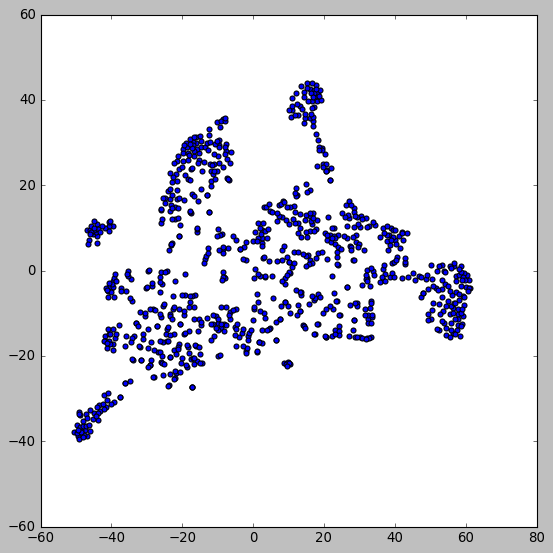

In [37]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
# construct a plot that plots and displays the training history
plt.style.use("classic")
plt.figure(figsize=(8,8))
plt.scatter(X_embedded[:,0], X_embedded[:,1])

In [38]:
import seaborn as sb

In [39]:
species = final["Organism"]
lut = dict(zip(species.unique(), "bgrcmy"))
row_colors = species.map(lut)

/people/shou626/.conda/envs/dl_tf/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 960x960 with 0 Axes>

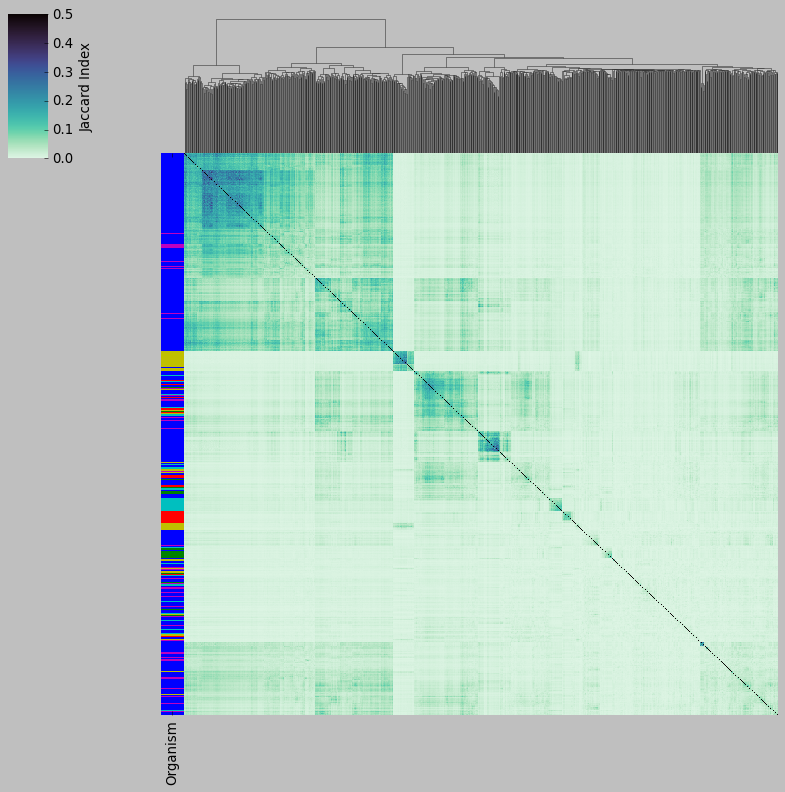

In [40]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
# construct a plot that plots and displays the training history
plt.style.use("classic")
plt.figure(figsize=(12,12))
cg = sb.clustermap(sim_mat, vmax=0.5, vmin=0, cmap="mako_r", row_colors=row_colors, 
             yticklabels=False,xticklabels=False, cbar_kws={'label': 'Jaccard Index'})
cg.ax_row_dendrogram.set_visible(False)
#cg.ax_column_dendrogram.set_visible(False)
#plt.savefig("heatmap_org_sia.png", dpi=400)

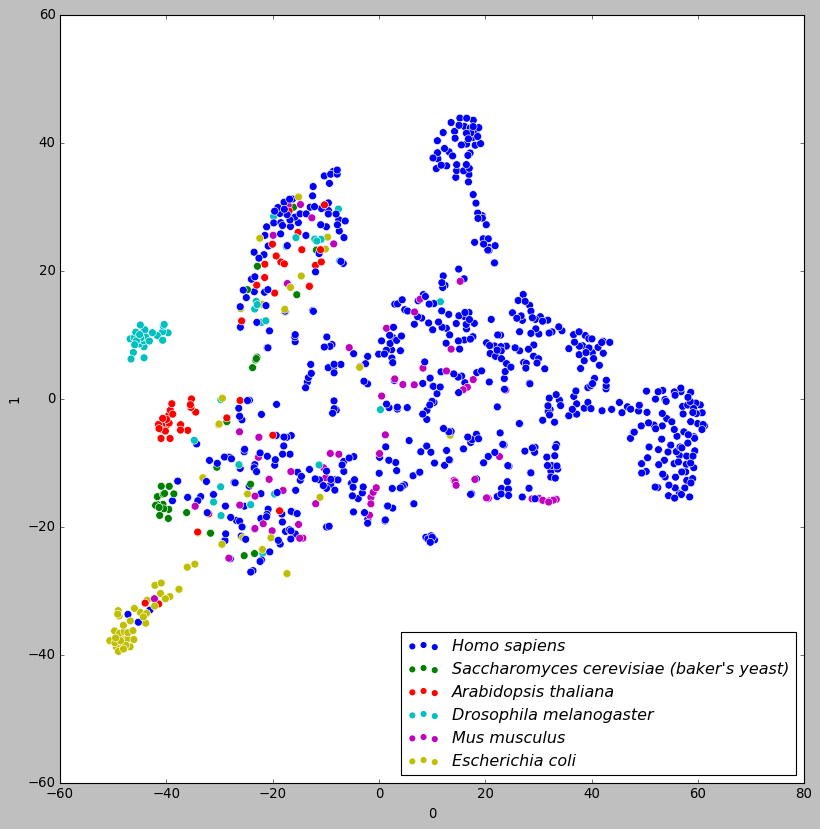

In [41]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
# construct a plot that plots and displays the training history
plt.style.use("classic")
plt.figure(figsize=(12,12))
sb.scatterplot(final, x=0, y=1, hue="Organism",
              s=50)
plt.legend(loc="lower right", 
          prop={'style': 'italic'})
#plt.savefig("tsne_sia.png", dpi=400)